# 1. GBDT应用

## 1.1 加载数据

In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier

X,y = datasets.load_iris(return_X_y = True)
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state = 1124)

## 1.2 一棵决策树（普通决策树）

In [3]:
model = DecisionTreeClassifier()
model.fit(X_train,y_train)

DecisionTreeClassifier()

In [4]:
print(model.score(X_test,y_test))
model.predict_proba(X_test)[:5]

0.868421052631579


array([[1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.],
       [1., 0., 0.],
       [0., 1., 0.]])

## 1.3 GBDT【集成算法】

In [7]:
set(y)

{0, 1, 2}

In [5]:
model = GradientBoostingClassifier(n_estimators=50,
                                   subsample=0.8,  # 采样
                                   learning_rate=0.005, # 学习率，梯度下降
                                   max_depth=None)  
model.fit(X_train,y_train)

GradientBoostingClassifier(learning_rate=0.005, max_depth=None, n_estimators=50,
                           subsample=0.8)

In [6]:
print(model.score(X_test,y_test))
model.predict_proba(X_test)[:5]

0.9473684210526315


array([[0.51595789, 0.22644293, 0.25759917],
       [0.51595789, 0.22644293, 0.25759917],
       [0.32663686, 0.36819361, 0.30516953],
       [0.51595789, 0.22644293, 0.25759917],
       [0.28157906, 0.45535158, 0.26306936]])

In [ ]:
# GBDT 概率计算用的 sigmoid

# 2. 模拟数据GBDT建模可视化

In [8]:
import numpy as np
# 集成，集成算法
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
import graphviz

## 2.1 创建数据

In [9]:
X = np.arange(1,11).reshape(-1,1)
X

array([[ 1],
       [ 2],
       [ 3],
       [ 4],
       [ 5],
       [ 6],
       [ 7],
       [ 8],
       [ 9],
       [10]])

In [11]:
y = np.array([0,0,0,1,1]*2)  # 5个 长度变成 10个
y

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 1])

## 2.2 构建GBDT训练和预测

In [12]:
model = GradientBoostingClassifier(n_estimators=3,  # loss='log_loss' 就是默认为交叉熵
                                   learning_rate=0.1,
                                   max_depth=1)

model.fit(X,y) # 建模，找规律！

GradientBoostingClassifier(max_depth=1, n_estimators=3)

In [13]:
y_ = model.predict(X)
print('真实类别：',y)
print('预测类别：',y_)

真实类别： [0 0 0 1 1 0 0 0 1 1]
预测类别： [0 0 0 0 0 0 0 0 1 1]


In [14]:
proba_ = model.predict_proba(X)
proba_[:5]

array([[0.66466915, 0.33533085],
       [0.66466915, 0.33533085],
       [0.66466915, 0.33533085],
       [0.6126304 , 0.3873696 ],
       [0.6126304 , 0.3873696 ]])

## 2.3 可视化

In [15]:
model

GradientBoostingClassifier(max_depth=1, n_estimators=3)

In [16]:
model[0]  # 还带一个中括号

array([DecisionTreeRegressor(criterion='friedman_mse', max_depth=1,
                             random_state=RandomState(MT19937) at 0x1056FC21640)],
      dtype=object)

In [17]:
model[0,0]

DecisionTreeRegressor(criterion='friedman_mse', max_depth=1,
                      random_state=RandomState(MT19937) at 0x1056FC21640)

In [18]:
# 第一棵树
data = tree.export_graphviz(model[0,0],filled=True)
graph = graphviz.Source(data)
graph.render('./第一棵树', format='png')  

'第一棵树.png'

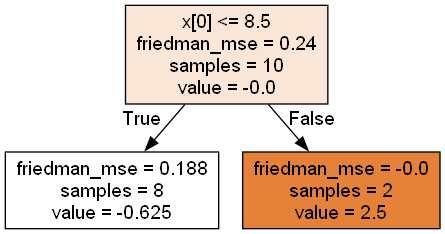

In [42]:
np.round(0.8 * 0.188,2)

0.15

In [19]:
# 第二棵树
data = tree.export_graphviz(model[1,0],filled=True)
graph = graphviz.Source(data)
graph.render('./第二棵树', format='png')  
# 裂分条件一样，但 mse 不一样了
# value 是 γ_mj

'第二棵树.png'

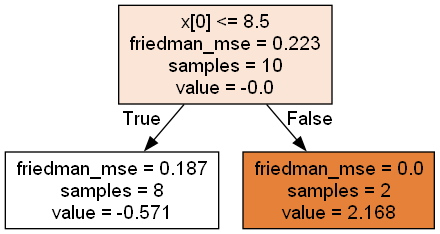

In [20]:
# 第三棵树
data = tree.export_graphviz(model[2,0],filled=True)
graph = graphviz.Source(data)
graph.render('./第三棵树', format='png') 
# 裂分条件和 value都变了

'第三棵树.png'

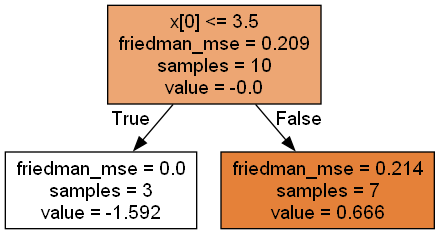

# 3. 算法模拟【自己写代码实现上述过程】【原理】

## 3.1 初始值计算

In [21]:
F0 = np.log(y.sum()/(1 - y).sum())
F0

-0.40546510810816444

In [22]:
# 10个样本，一开始时候，10个样本，都是这个初始值
# 随着梯度进行，差异就出现了
F0 = np.array([F0] * 10)
F0

array([-0.40546511, -0.40546511, -0.40546511, -0.40546511, -0.40546511,
       -0.40546511, -0.40546511, -0.40546511, -0.40546511, -0.40546511])

## 3.2 计算残差

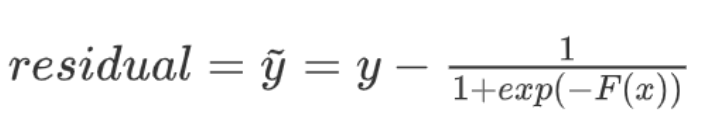

In [23]:
residual0 = y - 1/(1 + np.exp(-F0))
residual0

array([-0.4, -0.4, -0.4,  0.6,  0.6, -0.4, -0.4, -0.4,  0.6,  0.6])

In [24]:
mse = ((residual0 - residual0.mean())**2).mean()
mse

0.24

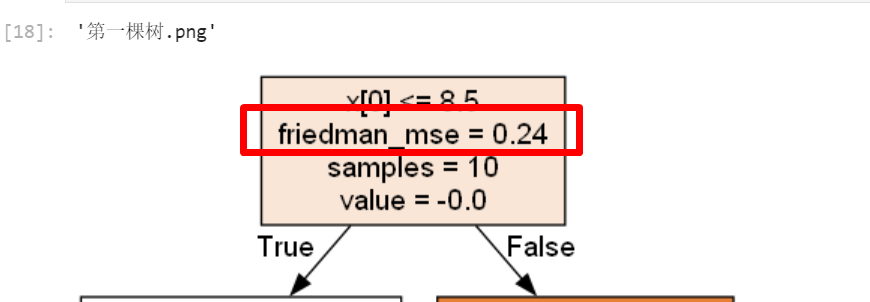

## 3.3 拟合第一棵树

In [38]:
residual0  # 长度为10，最后一个数值的索引为 9

array([-0.4, -0.4, -0.4,  0.6,  0.6, -0.4, -0.4, -0.4,  0.6,  0.6])

In [39]:
X.ravel()  

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

### 3.3.1 最佳分裂条件

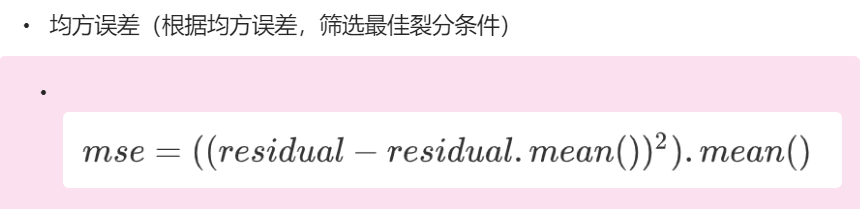 

In [25]:
lower_mse = 0.24# 初始
best_split = {}
for i in range(0,10):# i 从数字0开始 ，是X数值的索引  X = np.arange(1,11).reshape(-1,1)
    if i == 9:  # 运行到 9 了，相当于没有划分
        mse = ((residual0 - residual0.mean())**2).mean()
    else:
        left = residual0[:i+1] # 左闭右开
        right = residual0[i+1:]
        left_mse = ((left - left.mean())**2).mean()
        right_mse = ((right - right.mean())**2).mean()
        mse = left_mse * (i+1)/10 + right_mse * (10 -i -1)/10
    if lower_mse > mse:
        lower_mse = mse
        best_split.clear()
        best_split['X[0] <= '] = X[i:i+2].mean()
        
print('最小的mse是：',lower_mse)
print('最佳的裂分条件是：',best_split)

最小的mse是： 0.15
最佳的裂分条件是： {'X[0] <= ': 8.5}


In [26]:
round(0.188*0.8,2)

0.15

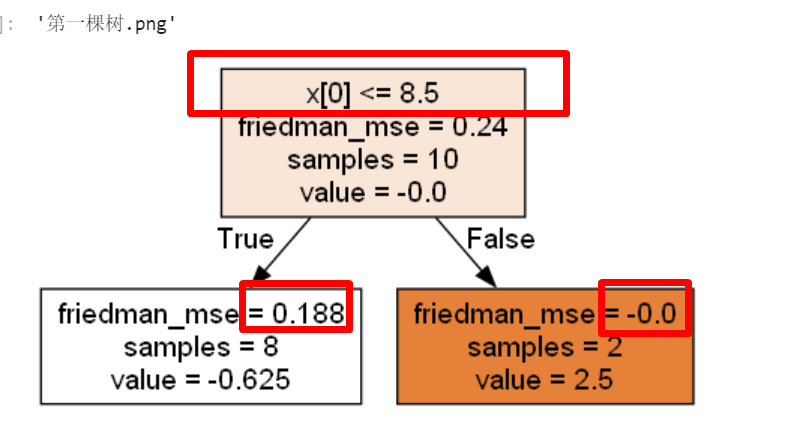

### 3.3.2 计算叶节点的value 

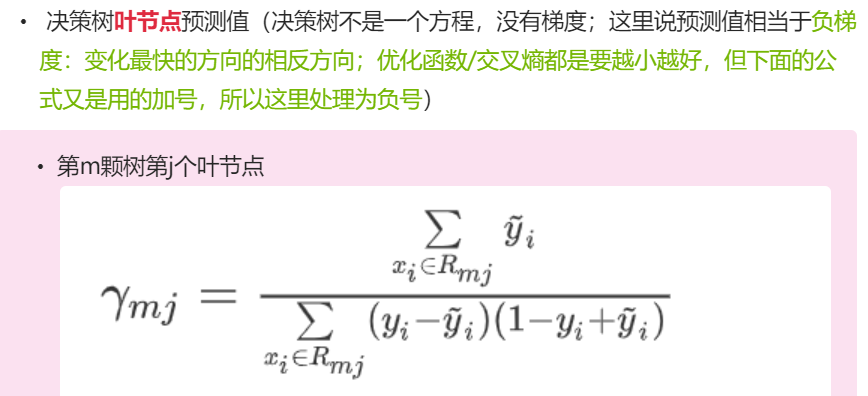

In [27]:
# 计算叶节点的value
# 左边的  X[0] <= 8.5
gamma1 = residual0[:8].sum()/((y[:8] - residual0[:8])*(1-y[:8] + residual0[:8])).sum()
np.round(gamma1,3)

-0.625

In [28]:
# 右边的  X[0] > 8.5
gamma2 = residual0[8:].sum()/((y[8:] - residual0[8:])*(1-y[8:] + residual0[8:])).sum()
np.round(gamma2,3)

2.5

### 3.3.3 梯度提升

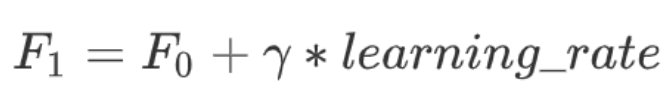

In [47]:
# 梯度提升
gamma = np.array([gamma1]*8 + [gamma2]*2)   # 这里相加就是拼接
learning_rate = 0.1

F1 = F0 + gamma * learning_rate
F1

array([-0.46796511, -0.46796511, -0.46796511, -0.46796511, -0.46796511,
       -0.46796511, -0.46796511, -0.46796511, -0.15546511, -0.15546511])

## 3.4 拟合第二棵树【根据F1进行计算】

In [28]:
# 根据F1计算残差
residual1 = y - 1/(1 + np.exp(-F1))
residual1

array([-0.38509799, -0.38509799, -0.38509799,  0.61490201,  0.61490201,
       -0.38509799, -0.38509799, -0.38509799,  0.53878818,  0.53878818])

In [30]:
mse = ((residual1 - residual1.mean())**2).mean()
np.round(mse,3)

0.223

In [31]:
# 有了残差，就可以裂分
lower_mse = 0.223 # 初始
best_split = {}
for i in range(0,10):# i 从数字0开始
    if i == 9:
        mse = ((residual1 - residual1.mean())**2).mean()
    else:
        left = residual1[:i+1] # 左闭右开
        right = residual1[i+1:]
        left_mse = ((left - left.mean())**2).mean()
        right_mse = ((right - right.mean())**2).mean()
        mse = left_mse * (i+1)/10 + right_mse * (10 -i -1)/10
    if lower_mse > mse:
        lower_mse = mse
        best_split.clear()
        best_split['X[0] <= '] = X[i:i+2].mean()
        
print('最小的mse是：',lower_mse)
print('最佳的裂分条件是：',best_split)

最小的mse是： 0.15
最佳的裂分条件是： {'X[0] <= ': 8.5}


In [34]:
# 计算叶节点gamma，value，负梯度
# 计算叶节点的value
gamma1 = residual1[:8].sum()/((y[:8] - residual1[:8])*(1-y[:8] + residual1[:8])).sum()
print(np.round(gamma1,3))

gamma2 = residual1[8:].sum()/((y[8:] - residual1[8:])*(1-y[8:] + residual1[8:])).sum()
print(np.round(gamma2,3))

-0.571
2.168


In [35]:
# 声明叶节点，负梯度
gamma = np.array([gamma1] * 8 + [gamma2]*2)  # 这里相加就是拼接
gamma

array([-0.57052111, -0.57052111, -0.57052111, -0.57052111, -0.57052111,
       -0.57052111, -0.57052111, -0.57052111,  2.16820117,  2.16820117])

In [36]:
# 梯度提升
F2 = F1 + gamma * learning_rate
F2

array([-0.52501722, -0.52501722, -0.52501722, -0.52501722, -0.52501722,
       -0.52501722, -0.52501722, -0.52501722,  0.06135501,  0.06135501])

## 3.5 拟合第三棵树【F2】

In [37]:
residual2 = y - 1/(1 + np.exp(-F2))
residual2

array([-0.37167979, -0.37167979, -0.37167979,  0.62832021,  0.62832021,
       -0.37167979, -0.37167979, -0.37167979,  0.48466606,  0.48466606])

In [38]:
# mse
mse = ((residual2 - residual2.mean())**2).mean()
np.round(mse,3)

0.209

In [39]:
# 有了残差，就可以裂分
lower_mse = 0.223# 初始
best_split = {}
for i in range(0,10):# i 从数字0开始
    if i == 9:
        mse = ((residual2 - residual2.mean())**2).mean()
    else:
        left = residual2[:i+1] # 左闭右开
        right = residual2[i+1:]
        left_mse = ((left - left.mean())**2).mean()
        right_mse = ((right - right.mean())**2).mean()
        mse = left_mse * (i+1)/10 + right_mse * (10 -i -1)/10
    if lower_mse > mse:
        lower_mse = mse
        best_split.clear()
        best_split['X[0] <= '] = X[i:i+2].mean()
        
print('最小的mse是：',lower_mse)
print('最佳的裂分条件是：',best_split)

最小的mse是： 0.1497502190152274
最佳的裂分条件是： {'X[0] <= ': 3.5}


In [42]:
# 计算叶节点gamma，value，负梯度
# 计算叶节点的value
gamma1 = residual2[:3].sum()/((y[:3] - residual2[:3])*(1-y[:3] + residual2[:3])).sum()
print(np.round(gamma1,3))

gamma2 = residual2[3:].sum()/((y[3:] - residual2[3:])*(1-y[3:] + residual2[3:])).sum()
print(np.round(gamma2,3))

-1.592
0.666


In [43]:
gamma = np.array([gamma1]*3 + [gamma2]*7)
gamma

array([-1.59154518, -1.59154518, -1.59154518,  0.66634692,  0.66634692,
        0.66634692,  0.66634692,  0.66634692,  0.66634692,  0.66634692])

In [44]:
# 决策树最终的结果，这个就是决策树的值
# 需要对F3进行sigmoid转换
F3 = F2 + gamma * learning_rate
F3

array([-0.68417174, -0.68417174, -0.68417174, -0.45838253, -0.45838253,
       -0.45838253, -0.45838253, -0.45838253,  0.1279897 ,  0.1279897 ])

## 3.6 概率计算

In [47]:
p = 1/(1 + np.exp(-F3))
np.c_[1-p,p]

array([[0.66466915, 0.33533085],
       [0.66466915, 0.33533085],
       [0.66466915, 0.33533085],
       [0.6126304 , 0.3873696 ],
       [0.6126304 , 0.3873696 ],
       [0.6126304 , 0.3873696 ],
       [0.6126304 , 0.3873696 ],
       [0.6126304 , 0.3873696 ],
       [0.46804618, 0.53195382],
       [0.46804618, 0.53195382]])

In [46]:
proba_  # proba_ = model.predict_proba(X)

array([[0.66466915, 0.33533085],
       [0.66466915, 0.33533085],
       [0.66466915, 0.33533085],
       [0.6126304 , 0.3873696 ],
       [0.6126304 , 0.3873696 ],
       [0.6126304 , 0.3873696 ],
       [0.6126304 , 0.3873696 ],
       [0.6126304 , 0.3873696 ],
       [0.46804618, 0.53195382],
       [0.46804618, 0.53195382]])